# Analysis of inducible reprogramming sorted at 14 dpi

Notes:

1. Replated at 14 dpi at 40k/96-well

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker
import seaborn as sns
import scipy
from statannotations.Annotator import Annotator
import rushd as rd
import re
from pathlib import Path

# 14 dpi data - sort

## Load data

In [3]:
# Directories
datadir = rd.datadir/'2024.09.13_inducibleLNI_14dpi'/'export_P3'
figpath = '../figures/fig3/'

# Store all data in list of dfs which will be converted to df at end
data_14dpi_P3 = list()

# Get all CVs
files = Path(datadir).glob('*.csv') 
for i, file in enumerate(files):

    # Extract metadata from csv title
    match = re.search(
        'export_Specimen_001_(?P<virus>.+)_(?P<SNAP>.+)_(?P<dox>.+)_(?P<rep>.+)_P3.csv', file.name)

    # Load as df and note header is on 0th row
    df = pd.read_csv(file, header=0)

    # Update columns in df with metadata from file name
    if match.group('virus') == 'retro':
        df['inducible_cat'] = False
    else:
        df['inducible_cat'] = True
    df['virus'] = match.group('virus')

    if match.group('SNAP') == 'SNAP':
        df['SNAP_cat'] = True
    else:
        df['SNAP_cat'] = False

    if match.group('dox') == 'Dox':
        df['Dox_cat'] = True
    else:
        df['Dox_cat'] = False

    df['rep'] = int(match.group('rep'))
    
    data_14dpi_P3.append(df)


# Convert list of dfs into single df
data_14dpi_P3 = pd.concat(data_14dpi_P3, ignore_index=True)

# Remove negative data
data_14dpi_P3 = data_14dpi_P3.loc[
    (data_14dpi_P3['FITC-A'] > 0) & 
    (data_14dpi_P3['APC-A'] > 0)
]


## Look at iMN purity at 14 dpi

### Gate iMNs

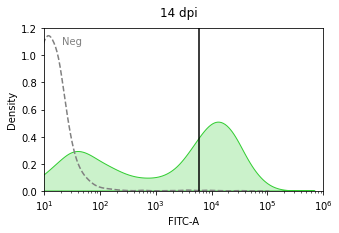

In [4]:
# Threshold for iMNs
eGFP_A_thresh = 6*10**3

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Plot eGFP-A
x = 'FITC-A'
hue = 'cond'

sns.kdeplot(ax=ax, data=data_14dpi_P3.loc[data_14dpi_P3.inducible_cat == False],
    x=x, color='limegreen',
    common_norm=False, log_scale=(True, False),
    fill=True)

# Plot neg ctrl
sns.kdeplot(data=data_14dpi_P3[(data_14dpi_P3.inducible_cat == True) & (data_14dpi_P3.Dox_cat == False)], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.1, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Title
plt.suptitle('14 dpi')
# Adjust limits
eGFP_lim = (10, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(eGFP_lim)

sub_ax.axvline(eGFP_A_thresh, 0, 1, color='black')

# plt.savefig(figpath + 'eGFP-dist.svg', bbox_inches='tight')

In [5]:
# Categorize iMNs based on eGFP_thresh
data_14dpi_P3['eGFP_cat'] = 'fib'
data_14dpi_P3.loc[(data_14dpi_P3['FITC-A'] > eGFP_A_thresh), 'eGFP_cat'] = 'iMN'

# Get total counts and percent of eGFP-H+
well_group = ['inducible_cat', 'virus', 'SNAP_cat', 'Dox_cat', 'rep']
count_df_reps = data_14dpi_P3.groupby([*well_group, 'eGFP_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if no eGFP-H+ rather than dropping row
percent_df_reps = (count_df_reps*100/count_df_reps.groupby([*well_group]).transform('sum')).dropna().reset_index(name='percent')

# Extract just the iMNs
data_iMN_percent = percent_df_reps.loc[(percent_df_reps['eGFP_cat'] == 'iMN')]

### iMN purity

In [6]:
# Make copy of just SNAP stained cells
df = data_iMN_percent.copy()
df = df.loc[df.SNAP_cat] 

for index, row in df.iterrows():
    if row.virus == 'retro':
        df.loc[index, 'cond'] = 'retro'
    elif row.virus == 'lenti':
        if row.Dox_cat == True:
            df.loc[index, 'cond'] = 'lenti_Dox'
        else:
            df.loc[index, 'cond'] = 'lenti_noDox'

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

lenti_noDox vs. lenti_Dox: t-test independent samples, P_val:7.959e-04 t=-9.138e+00
lenti_Dox vs. retro: t-test independent samples, P_val:3.424e-03 t=-6.209e+00


/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-engraftable-neurons/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position fou

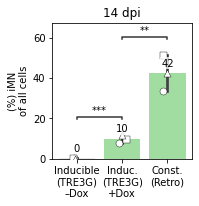

In [7]:
# General plotting params
x = 'cond'
y = 'percent'

marker_list = ['o', 's', '^', 'D', 'P', 'X'] 

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5))

# Plot lenti
order = ['lenti_noDox', 'lenti_Dox', 'retro']
palette = {'lenti_noDox': 'lightgray',
           'lenti_Dox': 'limegreen',
           'retro': 'limegreen'}

# Plot bar plot
g = sns.barplot(
    ax=ax, data=df,
    x=x, y=y, 
    order=order, palette=palette, alpha=0.5)
# Plot reps
for (i, rep) in enumerate(df.rep.unique()):
    sns.stripplot(
        ax=ax, data=df[df.rep == rep],
        x=x, y=y, order=order,
        dodge=True, marker=marker_list[i],
        color='white', size=7,
        edgecolor='black', linewidth=0.4,)


# Add in stats
pairs = [('lenti_noDox', 'lenti_Dox'), ('retro', 'lenti_Dox')]
annot = Annotator(ax=ax,
    data=df,
    x=x, y=y, pairs=pairs, 
    order=order)
annot.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annot.apply_test().annotate(line_offset_to_group=0.15)

# Add barplot labels
for i in ax.containers:
    bar_labels = ax.bar_label(i, fmt='%0.0f', padding=5)
    for label in bar_labels:
        label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))  

# Format
plt.title('14 dpi')
ax.set_xlabel('')
ax.yaxis.set_label_text('(%) iMN\nof all cells')
ax.set_yticks(np.arange(0, 65, 20))
ax.set_xticklabels(['Inducible\n(TRE3G)\n–Dox', 'Induc.\n(TRE3G)\n+Dox', 'Const.\n(Retro)'])

plt.savefig(figpath + 'SI/inducible_iMN_percent.svg', bbox_inches='tight')